<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#03-Advanced-spaCy" data-toc-modified-id="03-Advanced-spaCy-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>03 Advanced spaCy</a></span></li></ul></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transfer Learning</a></span></li></ul></div>

# SpaCy Tutorial
#### 03 Advanced spaCy

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
#!pip install spacy==2.3.0
#!python3.6 -m spacy validate
#!python3.6 -m spacy download en_trf_bertbaseuncased_lg
#!pip install  scikit-plot

     |████████████████████████████████| 10.0MB 9.3MB/s 
     |████████████████████████████████| 2.1MB 55.9MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
✔ Loaded compatibility table

====================== Installed models (spaCy v2.3.0) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                       
package   en-core-web-sm   en_core_web_sm   2.2.5   --> 2.3.0


============================== Install updates ==============================
Use the following commands to update the model packages:
python -m spacy download en_core_web_sm

     |████████████████████████████████| 405.8MB 163.0MB/s 
     |████████████████████████████████| 61kB 17.7MB/s 
     |████████████████████████████████| 71kB 21.6MB

In [1]:
import torch
import spacy
# Use CUDA tensor
if spacy.prefer_gpu():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")


In [2]:
import spacy
# Load model
nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/en_trf_bertbaseuncased_lg/en_trf_bertbaseuncased_lg-2.3.0')



In [3]:
# Pipeline is different from normal spaCy
print(nlp.pipe_names)

['sentencizer', 'trf_wordpiecer', 'trf_tok2vec']


### Transfer Learning  
The pretrained transformer models can be also used for transfer learning. Similar to computer vision's pretrained models (e.g. ResNet, Inception), you can start training on your smaller dataset with labels specific to your problem. Fine-tuning (changing the weights of the pretrained models) is possible by `nlp.update`.  

Transfer learning is only available for pre-defined spaCy's pipelines (for `spacy-transformers`, only `trf_textcat`), so it cannot be used for other unrelated tasks like reading comprehension.

In [4]:
%matplotlib inline
import spacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from spacy.util import decaying, minibatch, compounding
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot.plotters as skplt
from spacy.util import minibatch
import spacy_transformers
import pandas as pd
import unicodedata
from spacy_transformers.util import cyclic_triangular_rate
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/wiki_data.csv', encoding = 'utf8')

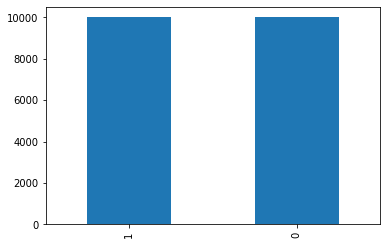

In [6]:
# Slighly imbalanced data
df.label.value_counts().plot(kind="bar");

In [11]:
#Splitting to train+val and test
df['Statements'] = df['Statements'].astype(str)
train_X, val_X, train_y, val_y = train_test_split(df[['Statements']], df[['label']].values,
                                                test_size = .20,
                                                random_state=1234)

In [12]:
train_X.shape, val_X.shape #, test_X.shape

((15998, 1), (4000, 1))

In [41]:
!pip install sklearn

In [15]:
# Converting the dataframe into a list of tuples
# change to dataframe to Spacy format
# wikidata citation needed text
import sklearn
from sklearn.utils import shuffle
df1 = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/wiki_random_test.csv', encoding = 'ISO-8859-1')
#test1 =df_tolist(df1)
df1[df1.columns[0]] = df1[df1.columns[0]].astype(str)
df1[df.columns[0]] = (df1[df1.columns[0]].map(lambda x: unicodedata.normalize('NFKD', str(x))))
df1 = sklearn.utils.shuffle(df1)
df1.head()

,statement,Label,Statements
8500,"Badlu (Persian: Ø¨Ø§Ø¯ÙÙâ , also Romanized...",1,"Badlu (Persian: Ø ̈Ø§Ø ̄ÙÙâ , also Roma..."
9440,"Dezg-e Pain (Persian: Ø¯Ø²Ú¯Ù¾Ø§ÙÙÙâ , al...",1,Dezg-e Pain (Persian: Ø ̄Ø2Ú ̄Ù3⁄4Ø§ÙÙÙ...
391,In such an environment (as opposed to smooth c...,1,In such an environment (as opposed to smooth c...
11935,A standard criterion for good large-scale maps...,0,A standard criterion for good large-scale maps...
2781,The David Linton Award of the British Society ...,1,The David Linton Award of the British Society ...


In [16]:

#Splitting to train and val
test_X, val1_X, test_y, val1_y = train_test_split(df1[['Statements']], df1[['Label']].values,
                                                  test_size = .50,
                                                  random_state=1)
                

In [17]:
import numpy as np
def prepare_data(data_X:pd.DataFrame=None, data_y:np.array=None, text_column:str='text'):
    labels = [{"1": bool(y), "0": not bool(y)} for y in data_y]
    texts = tuple(data_X[text_column].values.tolist())
    combined_data = list(zip(texts, [{"cats": cats} for cats in labels]))
    
    return combined_data, texts, labels

Padding is done automatically with subbatching, which regroups the batched sentences by sequence length, to minimise the amount of padding required. 

In [18]:
# Format data for spaCy
train_data, train_text, train_label = prepare_data(train_X, train_y, "Statements")
val_data, val_text, val_label = prepare_data(val_X, val_y, "Statements")
test_data, test_text, test_label = prepare_data(test_X, test_y, "Statements")

In [19]:
train_data[:10]

[("In addition, the 1987 film Superman IV: The Quest for Peace included a scene where a boy writes Superman a letter to control the nuclear arms race; according to Christopher Reeve, this scene was also inspired by Smith's story.",
  {'cats': {'0': False, '1': True}}),
 ('Exceptions include that a company in the oil and gas extraction industry may not accept group relief against the profits arising on its oil and gas extraction business, and a life assurance company may only accept group relief against its profits chargeable to tax at the standard shareholder rate applicable to that company',
  {'cats': {'0': False, '1': True}}),
 ('The present elevation of this beach line is the level of the Mono Lake high stand before the formation of the northern Mono Craters, plus any surface deformation that has happened since that time',
  {'cats': {'0': False, '1': True}}),
 ("Burnet reached the decision unilaterally, leaving many of the research staff disillusioned and feeling the action was ar

In [20]:
val_data[:10]

[("United Airlines Flight 93 was a domestic scheduled passenger flight that was hijacked by four Al-Qaeda terrorists on board, as part of the September 11 attacks. It crashed into a field in Somerset County, Pennsylvania, during an attempt by the passengers and crew to regain control. All 44 people aboard were killed, including the four hijackers, but no one on the ground was injured. The aircraft involved, a Boeing 757–222, was flying United Airlines' daily scheduled morning flight from Newark International Airport in New Jersey to San Francisco International Airport in California.",
  {'cats': {'0': True, '1': False}}),
 ("The pre-dreadnought age saw the beginning of the end of the 19th century naval balance of power in which France and Russia vied for competition against the massive British Royal Navy, and saw the start of the rise of the 'new naval powers' of Germany, Japan and the USA. The new ships of the Imperial Japanese Navy and to a lesser extent the U.S. Navy supported those

In [21]:
test_data[:10]

[('In October 2017 representatives from all three nations finally signed a joint declaration of intent as the first formal step towards submitting a bid for the Mont Blanc massif to be a candidate for inclusion on UNESCOâ\x80\x99s World Heritage Site list',
  {'cats': {'0': False, '1': True}}),
 ('Afermejan-e Sofla (Persian: Ø§Ù\x81Ø±Ù\x85Ø¬Ø§Ù\x86 Ø3Ù\x81Ù\x84Ù\x8aâ\x80\x8e , also Romanized as AfermejÄ\x81n-e SoflÃ¡; also known as AfermejÄ\x81n-e PÄ\x81â\x80\x99Ä«n) is a village in Reza Mahalleh Rural District, in the Central District of Rudsar County, Gilan Province, Iran',
  {'cats': {'0': False, '1': True}}),
 ('Germi is north of Ardabil in Iranian Azerbaijan. Germi is located 120Â km from Ardabil, the capital of the province. The yearly precipitation is 300Â mm and a temperature of (-10 to 36 Celsius) allows farmers to reach good yields in growing cereals. Germi is relatively new by Iranian standards; established in the year 900 of the Islamic calendar (1494 A.D.) 

In [22]:
# Create a pipeline for text classification
textcat = nlp.create_pipe("trf_textcat", config={"exclusive_classes": True, "architecture": "softmax_class_vector"})
for label in ("1", "0"):
    textcat.add_label(label)
nlp.add_pipe(textcat, last=True)

In [23]:
def decaying(start, stop, decay):
    """Yield an infinite series of linearly decaying values."""

    curr = float(start)
    while True:
        yield max(curr, stop)
        curr -= decay

In [24]:
# Evaluation function
def evaluate_classifier(nlp:spacy_transformers.language.TransformersLanguage=None, 
                        val_text:tuple=None, 
                        val_label:list=None, 
                        batch_size:int=32):
   
    proba_list = []
    label_list = []
    
    for i, doc in enumerate(nlp.pipe(val_text, batch_size=batch_size)):
        pred = doc.cats['1']
        label = 1.0 if val_label[i]['1'] else 0.0
        proba_list.append(pred)
        label_list.append(label)
    
    pred_indices = np.round(proba_list)
    accuracy = accuracy_score(label_list, pred_indices)
    roc_auc = roc_auc_score(label_list, proba_list)
    f1 = f1_score(label_list, pred_indices)
    precision = precision_score(label_list, pred_indices)
    recall = recall_score(label_list, pred_indices)
    
    return {'accuracy': accuracy, 'roc_auc': roc_auc, 'f1': f1, 'precision': precision, 'recall': recall}

In [25]:
# Optimizer (Adam)
optimizer = nlp.resume_training(use_gpu=True, device=0)
optimizer.alpha = 0.001
optimizer.trf_weight_decay = 0.005
optimizer.L2 = 0.0

In [26]:
import random
def train_classifier(n_epoch:int=5, 
                     train_data:list=None, 
                     val_text:tuple=None, 
                     val_label:list=None, 
                     batch_size:int=32, 
                     lr:float=1e-2):
    train_stats = []
    dropout = decaying(0.2, 0.1, 0.3) # Gradually decrease dropout rate from 0.2 to 0.1
    # Cyclic triangular rate (https://arxiv.org/abs/1506.01186)
    learn_rates = cyclic_triangular_rate(
        lr / 3, lr * 3, 2 * len(train_data) // batch_size
    )

    for epoch in range(n_epoch):
        random.shuffle(train_data)
      
        batches = minibatch(train_data, size=batch_size)
        losses = {}

        for batch in batches:
            optimizer.trf_lr = next(learn_rates)
       
            texts, cats = zip(*batch)
            nlp.update(
                texts, 
                cats, 
                drop = next(dropout),
                sgd = optimizer,
                losses=losses)

        print(f"Epoch: {epoch+1}")
        print(f"Losses: {losses}")
        
        with nlp.use_params(optimizer.averages):
            val_score = evaluate_classifier(nlp, val_text, val_label, batch_size)

        print(val_score)
        

        train_stats.append(losses)
        train_stats.append(val_score)

In [27]:
train_classifier(n_epoch=3, train_data=train_data, val_text=val_text, val_label=val_label, batch_size=32, lr=2e-6)

/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Epoch: 1
Losses: {'trf_textcat': 0.09973920204902242}
{'accuracy': 0.88075, 'roc_auc': 0.9091358070987943, 'f1': 0.8670197936994704, 'precision': 0.9829329962073325, 'recall': 0.7755610972568578}
Epoch: 2
Losses: {'trf_textcat': 0.11144203052754165}
{'accuracy': 0.85025, 'roc_auc': 0.91453034081463, 'f1': 0.8382392654604375, 'precision': 0.9140164899882215, 'recall': 0.774064837905237}
Epoch: 3
Losses: {'trf_textcat': 0.1030064594290252}
{'accuracy': 0.50125, 'roc_auc': 0.9583499896874356, 'f1': 0.6677768526228143, 'precision': 0.50125, 'recall': 1.0}


In [28]:
# Save the model
nlp.to_disk('/content/drive/MyDrive/ColabNotebooks/model/bert_textcat_waE3')

In [29]:
# Weight averaging (https://www.aclweb.org/anthology/P04-1015/)
with nlp.use_params(optimizer.averages):
    nlp.to_disk('/content/drive/MyDrive/ColabNotebooks/model/bert_textcat_waE3')
    


In [30]:
nlp_wa = spacy.load('/content/drive/MyDrive/ColabNotebooks/model/bert_textcat_waE3')

In [32]:
# Evaluate on test set
evaluate_classifier(nlp, test_text, test_label, 32)

{'accuracy': 0.9165165165165166,
 'f1': 0.9099157485418017,
 'precision': 0.981589373106502,
 'recall': 0.8479967787396819,
 'roc_auc': 0.9633353375359193}

In [29]:
# Evaluate on test set
evaluate_classifier(nlp_wa, test_text, test_label, 32)

{'accuracy': 0.9108571428571428,
 'f1': 0.9037037037037037,
 'precision': 0.961892247043364,
 'recall': 0.8521536670547147,
 'roc_auc': 0.9581638072615954}

In [33]:
# Predict function
def predict(nlp:spacy_transformers.language.TransformersLanguage=None, 
            val_text:tuple=None, 
            batch_size:int=32):
    
    proba_list = []
    
    for i, doc in enumerate(nlp.pipe(val_text, batch_size=batch_size)):
        pred = doc.cats['1']
        proba_list.append(pred)
    
    return proba_list

In [41]:
probas = predict(nlp, test_text)
pred_indices = np.round(probas)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


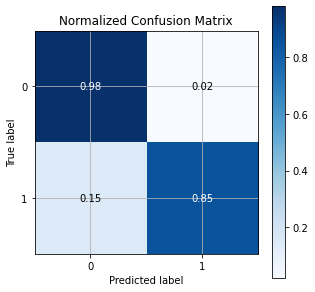

In [42]:
skplt.plot_confusion_matrix(test_y, pred_indices, figsize=(5,5), normalize=True);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


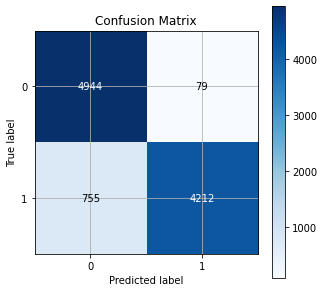

In [43]:
skplt.plot_confusion_matrix(test_y, pred_indices, figsize=(5,5), normalize=False);

In [44]:
# Calculate the best precision, recall, f1 score
def calc_prec_recall_f1(y_true:np.ndarray=None, y_pred:list=None):
    thresh_list = []
    thresholds = []
    for thresh in np.arange(0.01, 1.0, 0.01):
        thresh = np.round(thresh, 2)
        recall_res = recall_score(y_true, (y_pred > thresh).astype(int))
        prec_res = precision_score(y_true, (y_pred > thresh).astype(int))
        f1_res = f1_score(y_true, (y_pred > thresh).astype(int))
        thresh_list.append([thresh, recall_res, prec_res, f1_res])
        thresholds.append([thresh, recall_res, prec_res, f1_res])

    # Ordered by F-1 in descending
    thresholds.sort(key=lambda x: x[3], reverse=True)
    best_thresh = thresholds[0][0]
    best_recall = thresholds[0][1]
    best_prec = thresholds[0][2]
    best_f1 = thresholds[0][3]
    return  thresh_list, best_recall, best_prec, best_f1, best_thresh

In [45]:
thresh_list, best_recall, best_prec, best_f1, best_threshold = calc_prec_recall_f1(test_y, probas)
print(f'Optimal Recall: {best_recall} Precision: {best_prec} F1: {best_f1} at threshold: {best_threshold}')

Optimal Recall: 0.8510167102879002 Precision: 0.9793790546802595 F1: 0.9106969729613271 at threshold: 0.32


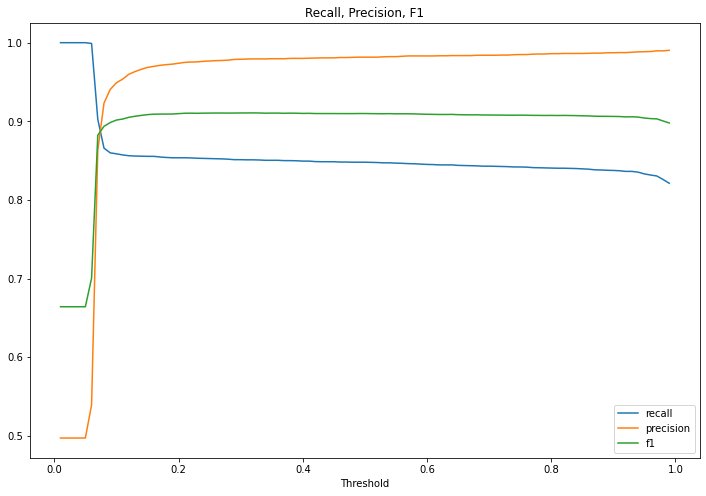

In [46]:
thresh_list = np.array(thresh_list)
threshold = thresh_list[:,0]
recall_list = thresh_list[:,1]
precision_list = thresh_list[:,2]
f1_list = thresh_list[:,3]

plt.figure(figsize = (12, 8))
plt.plot(threshold, recall_list, label='recall')
plt.plot(threshold, precision_list, label='precision')
plt.plot(threshold, f1_list, label='f1')
plt.title('Recall, Precision, F1')
plt.xlabel('Threshold')
plt.legend()
plt.show();

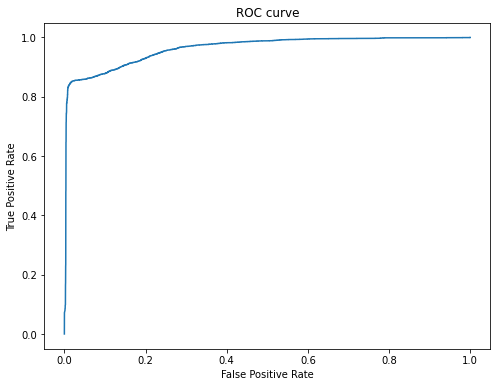

In [47]:
# ROC curve
fp, tp, thresholds = roc_curve(test_y, probas)

plt.figure(figsize = (8, 6))
plt.plot(fp, tp)
plt.title("ROC curve")
plt.xlabel( "False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show();

In [48]:
# Comparison between prediction and true label distribution
test_pd = pd.DataFrame(pred_indices, columns=['pred'])
test_pd['probas'] = probas

label_list = []

for i in test_label:
    label = 1.0 if i['1'] else 0.0
    label_list.append(label)
    
test_pd['label'] = label_list

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


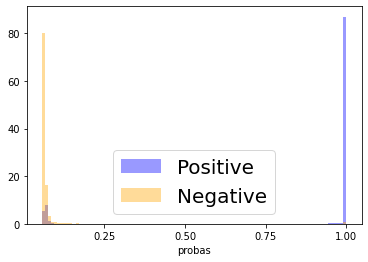

In [49]:
sns.distplot(test_pd[test_pd.label == 1].probas, kde=False, bins=100, color='blue', label='Positive', norm_hist=True)
sns.distplot(test_pd[test_pd.label == 0].probas, kde=False, bins=100, color='orange', label='Negative', norm_hist=True)

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 10
plt.legend();